In [2]:
# %pip install amazon-braket-sdk pandas numpy scikit-learn --quiet

import numpy as np
import pandas as pd

from braket.circuits import Circuit
from braket.devices import LocalSimulator
from braket.aws import AwsDevice, AwsSession

from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix


Ankaa-3 -> arn:aws:braket:us-west-1::device/qpu/rigetti/Ankaa-3
Aquila -> arn:aws:braket:us-east-1::device/qpu/quera/Aquila
Aria 1 -> arn:aws:braket:us-east-1::device/qpu/ionq/Aria-1
Aria 2 -> arn:aws:braket:us-east-1::device/qpu/ionq/Aria-2
Emerald -> arn:aws:braket:eu-north-1::device/qpu/iqm/Emerald
Forte 1 -> arn:aws:braket:us-east-1::device/qpu/ionq/Forte-1
Forte Enterprise 1 -> arn:aws:braket:us-east-1::device/qpu/ionq/Forte-Enterprise-1
Garnet -> arn:aws:braket:eu-north-1::device/qpu/iqm/Garnet

In [5]:
USE_LOCAL = False  # True => LocalSimulator (rápido/grátis); False => AWS

if USE_LOCAL:
    device = LocalSimulator()
else:
    # SV1 (exemplo). Ajuste região/ARN conforme sua conta.
    session = AwsSession()
    device = AwsDevice("arn:aws:braket:us-west-1::device/qpu/rigetti/Ankaa-3",
                       aws_session=session)

print("Device selecionado:", getattr(device, "name", type(device).__name__))


Device selecionado: Ankaa-3


In [6]:
df = pd.read_csv("metal_features_reduzido_com_y.csv")
features = ["Mendeleev", "Tmelt_K", "rcov_A", "d_band_center"]

X_raw = df[features].to_numpy(dtype=float)
y      = df["y"].to_numpy(dtype=int)
metals = df["metal"].astype(str).tolist()

print("X_raw:", X_raw.shape, "y:", y.shape)


X_raw: (9, 4) y: (9,)


In [7]:
def feature_map_circuit(x_norm, layers=1):
    """
    x_norm: array shape (4,) com valores em [0,1]
    Retorna um Circuit com:
      - Angle encoding: RY(pi*x_i) em cada qubit
      - Entanglement: CZ(0,1), CZ(1,2), CZ(2,3),
      - 'layers' vezes
    """
    assert len(x_norm) == 4
    c = Circuit()
    for _ in range(layers):
        # angle encoding
        for q, xi in enumerate(x_norm):
            c.ry(q, np.pi * xi)
        # entanglement chain
        c.cz(0, 1).cz(1, 2).cz(2, 3)
    # medição de todos os qubits (compatível com qualquer device)
    c = c.measure(0).measure(1).measure(2).measure(3)
    return c


def expvals_z_from_counts(counts, n_qubits=4):
    """
    Converte as contagens (dict bitstring->contagem) em <Z_i> para cada qubit i.
    Convenção Braket: bitstring é little-endian (qubit 0 é o bit da direita).
    Então usamos bit[-1-i] para acessar o qubit i.
    """
    shots = sum(counts.values())
    exp = np.zeros(n_qubits, dtype=float)
    for bitstring, c in counts.items():
        p = c / shots
        for i in range(n_qubits):
            bit_i = int(bitstring[-1 - i])  # qubit i é o bit da direita (little-endian)
            exp[i] += (1.0 if bit_i == 0 else -1.0) * p
    return exp  # vetor <Z_0>, <Z_1>, <Z_2>, <Z_3>


def quantum_features(device, X_norm, shots=2000, layers=1):
    """
    Calcula a matriz Φ (n_amostras x 4) com as expectativas <Z> por amostra.
    Para cada x, executa um circuito e converte contagens em <Z>.
    """
    Phi = np.zeros((len(X_norm), 4), dtype=float)
    for i, x in enumerate(X_norm):
        circ = feature_map_circuit(x, layers=layers)
        task = device.run(circ, shots=shots)
        counts = task.result().measurement_counts  # dict 'bitstring'->contagem
        Phi[i] = expvals_z_from_counts(counts, n_qubits=4)
    return Phi


In [8]:
scaler_demo = MinMaxScaler().fit(X_raw)
x_demo = scaler_demo.transform(X_raw[[0]])[0]
print(feature_map_circuit(x_demo, layers=1))


T  : │     0      │  1  │  2  │  3  │  4  │
      ┌──────────┐                   ┌───┐ 
q0 : ─┤ Ry(0.00) ├───●───────────────┤ M ├─
      └──────────┘   │               └───┘ 
      ┌──────────┐ ┌─┴─┐             ┌───┐ 
q1 : ─┤ Ry(2.40) ├─┤ Z ├───●─────────┤ M ├─
      └──────────┘ └───┘   │         └───┘ 
      ┌──────────┐       ┌─┴─┐       ┌───┐ 
q2 : ─┤ Ry(2.57) ├───────┤ Z ├───●───┤ M ├─
      └──────────┘       └───┘   │   └───┘ 
      ┌──────────┐             ┌─┴─┐ ┌───┐ 
q3 : ─┤ Ry(0.68) ├─────────────┤ Z ├─┤ M ├─
      └──────────┘             └───┘ └───┘ 
T  : │     0      │  1  │  2  │  3  │  4  │


In [9]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def logloss(w, b, Phi, y):
    z = Phi @ w + b
    p = sigmoid(z)
    eps = 1e-10
    return -np.mean(y * np.log(p + eps) + (1 - y) * np.log(1 - p + eps))

def logloss_grad(w, b, Phi, y):
    z = Phi @ w + b
    p = sigmoid(z)
    n = Phi.shape[0]
    grad_w = (Phi.T @ (p - y)) / n
    grad_b = np.mean(p - y)
    return grad_w, grad_b

def fit_logreg(Phi, y, lr=0.3, epochs=400, w0=None, b0=0.0):
    d = Phi.shape[1]
    w = np.zeros(d) if w0 is None else w0.copy()
    b = float(b0)
    for _ in range(epochs):
        gw, gb = logloss_grad(w, b, Phi, y)
        w -= lr * gw
        b -= lr * gb
    return w, b

def predict_logreg(w, b, phi_row, thr=0.5):
    p1 = float(sigmoid(phi_row @ w + b))
    return (1 if p1 >= thr else 0), p1


In [ ]:
SHOTS   = 1 #mudar para 2000     # QPU: 500–2000; Local/Simulador pode ser maior
LAYERS  = 1        # 0/1/2 — profundidade do feature map; QPU: comece com 0 ou 1
LR      = 0.3
EPOCHS  = 0 #mudar para 400

loo = LeaveOneOut()
y_true, y_pred, y_prob = [], [], []

for tr, te in loo.split(X_raw):
    # Normaliza só no treino
    scaler = MinMaxScaler().fit(X_raw[tr])
    Xtr = scaler.transform(X_raw[tr])
    Xte = scaler.transform(X_raw[te])

    # Extrai Φ no device
    Phi_tr = quantum_features(device, Xtr, shots=SHOTS, layers=LAYERS)  # (n_tr,4)
    Phi_te = quantum_features(device, Xte, shots=SHOTS, layers=LAYERS)  # (1,4)

    # Treina regressão logística clássica em Φ
    w, b = fit_logreg(Phi_tr, y[tr], lr=LR, epochs=EPOCHS)

    # Prediz o item de teste
    yhat, p1 = predict_logreg(w, b, Phi_te[0])
    y_true.append(y[te][0])
    y_pred.append(yhat)
    y_prob.append(p1)

acc = accuracy_score(y_true, y_pred)
cm  = confusion_matrix(y_true, y_pred, labels=[0,1])

print(f"[QLR (pura) | {getattr(device, 'name', type(device).__name__)}] LOO acc = {acc:.3f}")
print("Confusion [rows=true 0,1 ; cols=pred 0,1]:\n", cm)

res = pd.DataFrame({
    "metal": metals,
    "y_true": y_true,
    "qlr_pred": y_pred,
    "qlr_proba_1": np.round(y_prob, 3),
    "ok": (np.array(y_true) == np.array(y_pred))
})
display(res)


[QLR (pura) | Ankaa-3] LOO acc = 0.889
Confusion [rows=true 0,1 ; cols=pred 0,1]:
 [[3 1]
 [0 5]]


,metal,y_true,qlr_pred,qlr_proba_1,ok
0,Rh1,1,1,0.991,True
1,Ir1,1,1,0.749,True
2,Ni1,1,1,0.764,True
3,Pd1,1,1,0.727,True
4,Pt1,1,1,0.916,True
5,Cu1,0,1,0.603,False
6,Ag1,0,0,0.090,True
7,Au1,0,0,0.302,True
8,Pb1,0,0,0.194,True


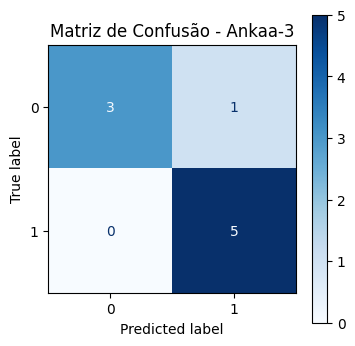

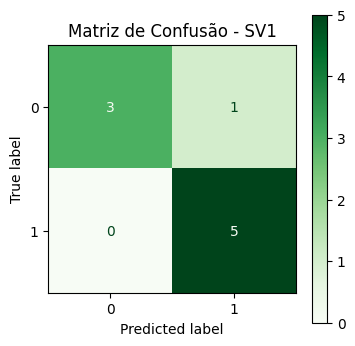

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# -----------------------------------------------------------
# Confusion matrix Tabela 1
# -----------------------------------------------------------
cm1 = confusion_matrix(df1["y_true"], df1["qlr_pred"], labels=[0,1])
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=[0,1])

fig, ax = plt.subplots(figsize=(4,4))
disp1.plot(ax=ax, cmap="Blues", values_format="d")
plt.title("Matriz de Confusão - Ankaa-3")
plt.show()

# -----------------------------------------------------------
# Confusion matrix Tabela 2
# -----------------------------------------------------------
cm2 = confusion_matrix(df2["y_true"], df2["qlr_pred"], labels=[0,1])
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=[0,1])

fig, ax = plt.subplots(figsize=(4,4))
disp2.plot(ax=ax, cmap="Greens", values_format="d")
plt.title("Matriz de Confusão - SV1")
plt.show()


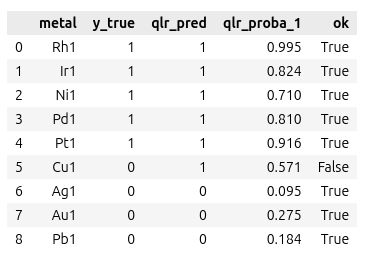

In [17]:
from qiskit import QuantumCircuit
from qiskit.visualization import circuit_drawer

# Criar circuito com 4 qubits + 4 bits clássicos
qc = QuantumCircuit(4, 4)

# Rotations RY (valores aproximados do seu exemplo)
qc.ry(0.00, 0)     # q0
qc.ry(2.40, 1)     # q1
qc.ry(2.57, 2)     # q2
qc.ry(0.68, 3)     # q3

# Cadeia de CZ (encadeamento como no seu diagrama)
qc.cz(0, 1)
qc.cz(1, 2)
qc.cz(2, 3)

# Medições
qc.measure([0,1,2,3], [0,1,2,3])

# Desenhar no estilo matplotlib (para artigo)
qc.draw("mpl", filename="feature_map.png")  # salva a figura


MissingOptionalLibraryError: "The 'pylatexenc' library is required to use 'MatplotlibDrawer'. You can install it with 'pip install pylatexenc'."

In [15]:
!pip install pylatexenc
